Notebook based on Karnika Kapoor Work: [LINK](https://www.kaggle.com/code/karnikakapoor/music-generation-lstm)

In [1]:
#Importing Libraries
import tensorflow 
import numpy as np 
import pandas as pd 
from collections import Counter
import random
import IPython
from IPython.display import Image, Audio
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adamax
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
import sys
import os
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")
np.random.seed(42)

In [2]:
# Added to the enviroment
#!pip install music21
# Dependencies
#brew install lilypond

# Exploración de los Datos

In [3]:
import music21
from music21 import *

### Cargando la data MIDI. 

La fuente son pianos de música clásica del conocido autor Frédéric Chopin. 

- Los archivos MIDIS son leídos a través de la libreria ```music21```

- Luego, se extraen notas y acordes desde esta información para crear un corpus para entrenar el modelo. 


In [4]:
#Loading the list of chopin's midi files as stream 
filepath = "./data/chopin/"
#Getting midi files
all_midis= []
for i in os.listdir(filepath):
    if i.endswith(".mid"):
        tr = filepath+i
        midi = converter.parse(tr)
        all_midis.append(midi)

Cada archivo es un objeto del tipo ```music21``` que se puede "stremear" es decir es una secuencia continua de archivos MIDI que se reproducen uno tras otro en un flujo continuo o en tiempo real.

In [5]:
all_midis[0]

<music21.stream.Score 0x2caf44590>

In [6]:
#Helping function: extrae notas y acordes (métodos heredados de music21)        
def extract_notes(file):
    notes = []
    pick = None
    for j in file:
        songs = instrument.partitionByInstrument(j)
        for part in songs.parts:
            pick = part.recurse()
            for element in pick:
                if isinstance(element, note.Note):
                    notes.append(str(element.pitch))
                elif isinstance(element, chord.Chord):
                    notes.append(".".join(str(n) for n in element.normalOrder))

    return notes

Extracción de Notas y Acordes

In [7]:
#Getting the list of notes as Corpus
Corpus= extract_notes(all_midis)
print("Total notes in all the Chopin midis in the dataset:", len(Corpus))

Total notes in all the Chopin midis in the dataset: 57894


Observemos algunas de las notas presentes en el Corpus

In [8]:
N = 40
print(f"Primeros {N} valores presentes en el  Corpus:", Corpus[:N])

Primeros 40 valores presentes en el  Corpus: ['C3', 'C2', 'E-3', 'E-2', 'G#3', 'G#2', 'B-3', 'B-2', 'C4', 'C3', 'G#3', 'G#2', 'E-4', 'E-3', 'B-4', 'B-3', 'C5', 'C4', 'G#4', 'G#3', 'E-5', 'E-4', 'B-5', 'B-4', 'C6', 'C5', 'G5', 'G4', 'B-5', 'B-4', 'G#5', 'G#4', 'G5', 'G4', 'F#5', 'F#4', 'F#5', 'F#4', 'G5', 'G4']


Observando la partitura

In [9]:
#First Lets write some functions that we need to look into the data
def show(music):
    display(Image(str(music.write("lily.png"))))
    
def chords_n_notes(Snippet):
    Melody = []
    offset = 0 #Incremental
    for i in Snippet:
        #If it is chord
        if ("." in i or i.isdigit()):
            chord_notes = i.split(".") #Seperating the notes in chord
            notes = [] 
            for j in chord_notes:
                inst_note=int(j)
                note_snip = note.Note(inst_note)            
                notes.append(note_snip)
                chord_snip = chord.Chord(notes)
                chord_snip.offset = offset
                Melody.append(chord_snip)
        # pattern is a note
        else: 
            note_snip = note.Note(i)
            note_snip.offset = offset
            Melody.append(note_snip)
        # increase offset each iteration so that notes do not stack
        offset += 1
    Melody_midi = stream.Stream(Melody)   
    return Melody_midi

In [11]:
### Pendiente: exportar correctamente el path
#Melody_Snippet = chords_n_notes(Corpus[:100])
#show(Melody_Snippet)

Algunas estadísticas sobre total de notas, frecuencia de repetición de notas, la mayor frecuencia y la menor frecuencia

In [ ]:
#Creating a count dictionary
count_num = Counter(Corpus)
print("Total unique notes in the Corpus:", len(count_num))

Total unique notes in the Corpus: 397


In [ ]:
#Exploring the notes dictionary
Notes = list(count_num.keys())
Recurrence = list(count_num.values())
#Average recurrenc for a note in Corpus
def Average(lst):
    return sum(lst) / len(lst)
print("Average recurrenc for a note in Corpus:", Average(Recurrence))
print("Most frequent note in Corpus appeared:", max(Recurrence), "times")
print("Least frequent note in Corpus appeared:", min(Recurrence), "time")

Average recurrenc for a note in Corpus: 145.8287153652393
Most frequent note in Corpus appeared: 1627 times
Least frequent note in Corpus appeared: 1 time


Lo anterior implica notas que son "raras" dentro de la base de datos. Esto puede "sesgar" el modelo a tocar ciertas notas con mayor frecuencia. Idealmente quisieramos una distribución uniforme a lo largo de las notas. En este ejemplo, se eliminarán las notas raras, en desmedro de la obra de Chopin pues se quitarán notas "raras" dentro del dataset solo a modo de ejemplo. 

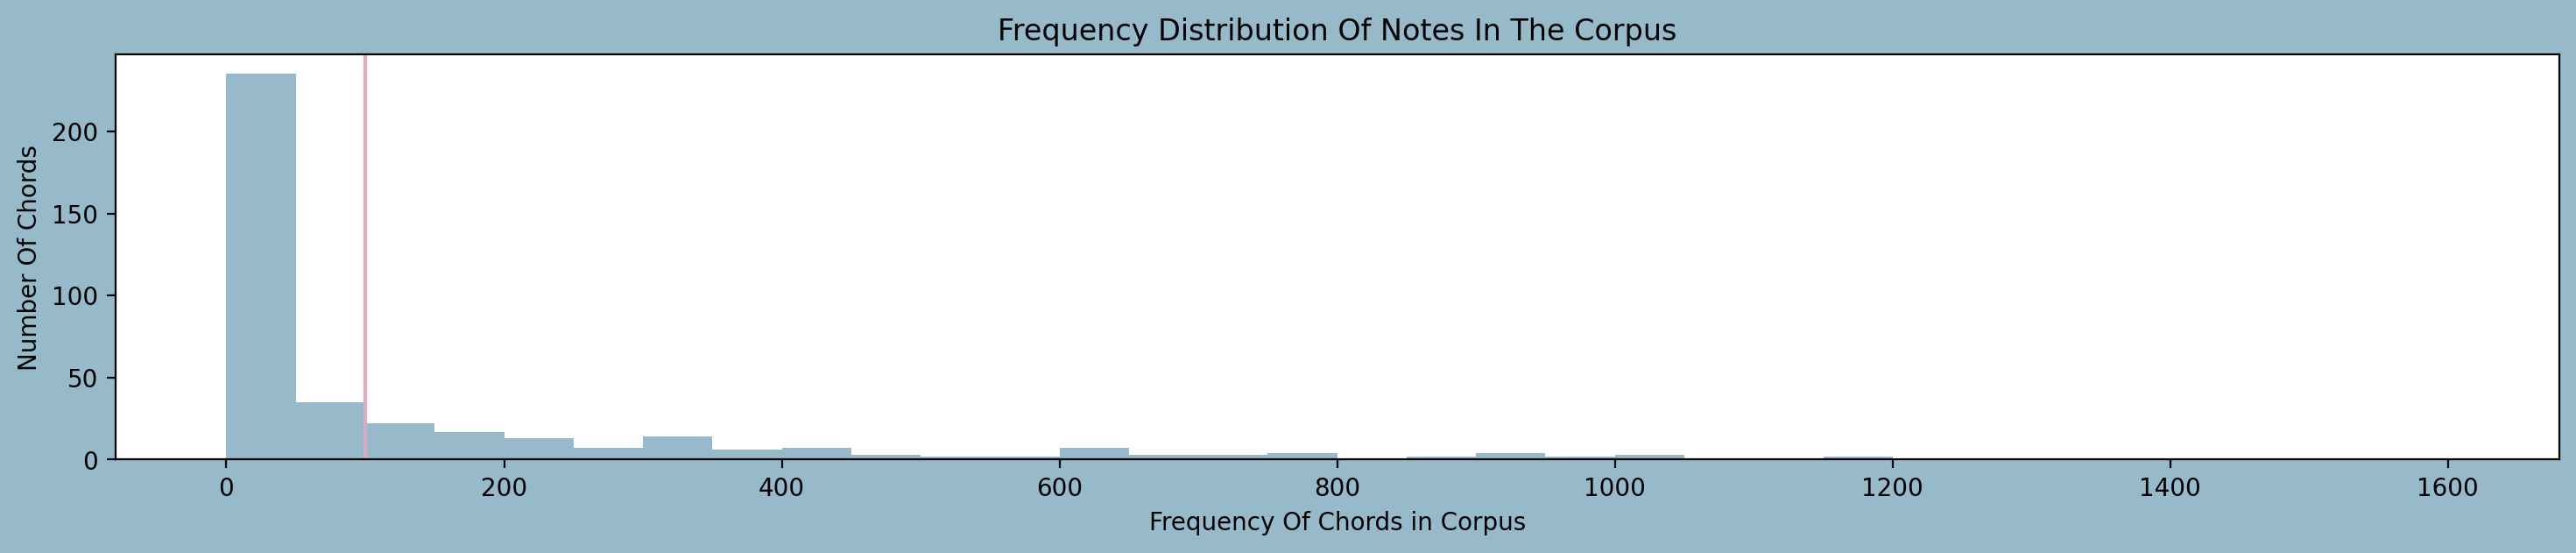

In [ ]:
# Plotting the distribution of Notes
plt.figure(figsize=(18,3),facecolor="#97BACB")
bins = np.arange(0,(max(Recurrence)), 50) 
plt.hist(Recurrence, bins=bins, color="#97BACB")
plt.axvline(x=100,color="#DBACC1")
plt.title("Frequency Distribution Of Notes In The Corpus")
plt.xlabel("Frequency Of Chords in Corpus")
plt.ylabel("Number Of Chords")
plt.show()

Eliminaremos las notas que han sido tocadas menos de 100 veces pero dejaré como hiperparámetro este valor para que puedan jugar y modificarlo. 

In [ ]:
Number_of_Notes = 100

#Getting a list of rare chords
rare_note = []
for index, (key, value) in enumerate(count_num.items()):
    if value < Number_of_Notes:
        m =  key
        rare_note.append(m)
        
print("Total number of notes that occur less than 100 times:", len(rare_note))

Total number of notes that occur less than 100 times: 270


Eliminación de las notas "raras"

In [ ]:
#Eleminating the rare notes
for element in Corpus:
    if element in rare_note:
        Corpus.remove(element)

print("Length of Corpus after elemination the rare notes:", len(Corpus))

Length of Corpus after elemination the rare notes: 53752


# Preprocesamiento

1 - Mapea las notas a números

In [12]:
# Storing all the unique characters present in my corpus to bult a mapping dic. 
symb = sorted(list(set(Corpus)))

L_corpus = len(Corpus) #length of corpus
L_symb = len(symb) #length of total unique characters

#Building dictionary to access the vocabulary from indices and vice versa
mapping = dict((c, i) for i, c in enumerate(symb))
reverse_mapping = dict((i, c) for i, c in enumerate(symb))

print("Total number of characters:", L_corpus)
print("Number of unique characters:", L_symb)

Total number of characters: 57894
Number of unique characters: 397


Observemos un ejemplo

In [14]:
mapping['G2']

392

In [15]:
reverse_mapping[392]

'G2'

2 - Crea los conjuntos de características y objetivos (Features and Targets). Recorre el Corpus en saltos de largo 40 y deja 40 notas como input y una como salida esperada de esa secuencia.

In [16]:
#Splitting the Corpus in equal length of strings and output target
length = 40
features = []
targets = []
for i in range(0, L_corpus - length, 1):
    feature = Corpus[i:i + length]
    target = Corpus[i + length]
    features.append([mapping[j] for j in feature])
    targets.append(mapping[target])
    
    
L_datapoints = len(targets)
print("Total number of sequences in the Corpus:", L_datapoints)

Total number of sequences in the Corpus: 57854


Observemos

In [22]:
len(features[0])

40

In [19]:
features[0][:10]

[346, 345, 360, 359, 387, 386, 327, 326, 347, 346]

In [21]:
targets[0]

376

3 - Modifica la forma o shape del arreglo para poder posteriormente entrenar un modelo utilizando ```keras```. Además convierte los targets vectores de 0-1 donde la posición de la componente 1 representa el número entero del mapa que codificó las notas previamente. Esto se denomina un "one hot vector. 

In [23]:
# reshape X and normalize
X = (np.reshape(features, (L_datapoints, length, 1)))/ float(L_symb)
# one hot encode the output variable
y = tensorflow.keras.utils.to_categorical(targets) 

Observemos

In [24]:
X.shape

(57854, 40, 1)

In [25]:
y.shape

(57854, 397)

In [26]:
y[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

3 - Divide en conjunto de entrenamiento y test: un $20\%$ de los datos serán para test.

In [27]:
#Taking out a subset of data to be used as seed
X_train, X_seed, y_train, y_seed = train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:
X_train.shape[1]

40

In [29]:
X_train.shape[2]

1

# Construcción del Modelo

- El modelo recibe como entrada un vector columna de la forma ```input_shape=(X.shape[1], X.shape[2]) = (40,1)```.
Se asigna el valor ```return_sequences = True``` para que la salida del modelo sea una secuencia completa y no el último valor o componente. 
Se suele utilizar ```return_sequences = False``` en problemas de clasificación. 


- Existe un mecanismo de regularización o control de los pesos del modelo para evitar el overfitting o sobre entrenamiento. ```Dropout(0.1)``` Significa que aproximadamente el $10\%$ de las neuronas de la capa anterior se desactivarán (se establecerán en cero) de manera aleatoria en cada paso de entrenamiento.

- Observe que utiliza una red neuronal totalmente conectada o modelo lineal visto en clases anteriores ```Dense(256)``` y dos modelos LSTM.

- Finalmente, utiliza una función de activación ```softmax``` para extraer el valor más probable como salida a la secuencia de entrada. 

- En mi computador aparece el siguiente Warning: 

```
WARNING:absl:At this time, the v2.11+ optimizer `tf.keras.optimizers.Adamax` runs slowly on M1/M2 Macs, please use the legacy Keras optimizer
```

In [30]:
#Initialising the Model
model = Sequential()
#Adding layers
model.add(LSTM(512, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(256))
model.add(Dense(256))
model.add(Dropout(0.1))
model.add(Dense(y.shape[1], activation='softmax'))
#Compiling the model for training  
opt = Adamax(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=opt)